In [13]:
import pandas as pd, numpy as np, os
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
from scipy.signal import find_peaks
from sklearn.manifold import TSNE
print('...')

...


In [14]:
def remove_unknown_unavailable(data_path):
    df = pd.read_csv(data_path)
    unwanted_values = ['unavailable', 'unknown']
    df.replace(unwanted_values, np.nan, inplace=True)
    df_cleaned = df.dropna().copy()
    
    for i in reversed(list(df_cleaned.index)[1:]):
        # Compare the current row's sensor status with the previous row's sensor status
        if df_cleaned.loc[i].sensor_status == df_cleaned.iloc[df_cleaned.index.get_loc(i)-1].sensor_status:
            # Drop the current row if the statuses match
            df_cleaned.drop([i], inplace=True)
            
    np_array = np.array(df_cleaned, dtype='object')
    return df_cleaned, np_array

def get_available_months_years(np_array, column_number_with_time = 2):
    timestamps = np_array[:, column_number_with_time].astype(int)
    datetime_values = [datetime.fromtimestamp(ts / 1000) for ts in timestamps]
    dates = pd.to_datetime(datetime_values)
    periods = dates.to_period('M')
    unique_periods = np.unique(periods)
    return unique_periods

def extract_monthly_data(np_array, target_month = '2024-03'):
    df = pd.DataFrame(np_array, columns=['sensor_id', 'value', 'timestamp', 'subject_id'])
    df['timestamp'] = pd.to_datetime(df['timestamp'].astype(int), unit='ms')
    target_period = pd.Period(target_month, freq='M')
    df.set_index('timestamp', inplace=True)
    filtered_df = df[df.index.to_period('M') == target_period]
    indices = filtered_df.index
    filtered_np_array = filtered_df.reset_index().values
    return filtered_df, indices, filtered_np_array

def filter_consecutive_on_and_off_in_real_valued_sensor(df):
    valid_indices = []
    for i in range(len(df) - 1):
        if df.loc[i, 'sensor_status'] == 'on' and df.loc[i + 1, 'sensor_status'] == 'off':
            valid_indices.append(i)
            valid_indices.append(i + 1)
    filtered_df = df.iloc[valid_indices]
    return filtered_df

def time_current_off_and_next_on(df):
    results = []
    for i in range(len(df)-1):
        ts_off = df.loc[i, 'ts_off']
        next_ts_on = df.loc[i + 1, 'ts_on']
        results.append({'ts_off': ts_off, 'next_ts_on': next_ts_on, 'difference': np.abs(next_ts_on - ts_off)})
    return results

def plot_data_with_peaks(df, time_col, value_col, peaks):
    df[time_col] = pd.to_datetime(df[time_col], unit='ms')
    df_peaks = df.iloc[peaks]    
    fig = px.line(df, x=time_col, y=value_col, title='Data with Peaks')
    fig.add_trace(
        go.Scatter(
            x=df_peaks[time_col],
            y=df_peaks[value_col],
            mode='markers',
            name='Peaks',
            marker=dict(color='red', size=10, symbol='x')
        )
    )
    fig.update_layout(
        xaxis_title='Timestamp',
        yaxis_title='Value',
        legend_title='Legend',
        template='plotly_white'
    )
    fig.update_yaxes(range=[df[value_col].min() - 1, df[value_col].max() + 1])
    fig.show()


def filter_sensors_by_window(df, start_time, end_time):
    # Convert 'ts_on' and 'ts_off' to datetime if they aren't already
    df['ts_on'] = pd.to_datetime(df['ts_on'])
    df['ts_off'] = pd.to_datetime(df['ts_off'])
    
    # Convert start_time and end_time to datetime
    start_time = pd.to_datetime(start_time)
    end_time = pd.to_datetime(end_time)
    
    # Filter rows where the sensor was active in the window
    active_sensors = df[((df['ts_on'] <= end_time) & (df['ts_off'] >= start_time))]
    
    return active_sensors

def filter_data_for_date(df, date_str):
    date = pd.to_datetime(date_str)
    filtered_df = df[(df['ts_on'].dt.date == date.date()) | (df['ts_off'].dt.date == date.date())]
    # filtered_df = df.loc[(df['ts_on'].dt.date == date) | (df['ts_off'].dt.date == date)]

    if filtered_df.empty:
        # print(f"No data found for the date: {date_str}")
        return filtered_df
    else:
        return filtered_df
    
def prepare_plot_data(date_specific_data):
    plot_data = []
    
    for entry in date_specific_data:
        sensor_name = entry['sensor']
        sensor_data = entry['data']
        
        if not sensor_data.empty:
            # Extracting the active periods
            for index, row in sensor_data.iterrows():
                plot_data.append({
                    'sensor': sensor_name,
                    'start_time': row['ts_on'],
                    'end_time': row['ts_off']
                })
    
    return pd.DataFrame(plot_data)

def plot_tsne(sample_size, data):
    # Aggregate data into samples
    aggregated_data = []
    for i in range(0, len(data), sample_size):
        sample = data[i:i+sample_size]
        if len(sample) == sample_size:
            aggregated_data.append(sample['sensor_status'].values)
    aggregated_data = np.array(aggregated_data)
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=5, random_state=0)
    tsne_results = tsne.fit_transform(aggregated_data)
    
    # Plot the t-SNE results
    plt.figure(figsize=(12, 8))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], cmap='viridis', alpha=0.6)
    plt.colorbar(label='Sensor Status')
    plt.xlabel('t-SNE Feature 1')
    plt.ylabel('t-SNE Feature 2')
    plt.title(f't-SNE Plot with Sample Size {sample_size}')
    plt.show()

def remove_unknown_unavailable_v2(df):
    unwanted_values = ['unavailable', 'unknown']
    df.replace(unwanted_values, np.nan, inplace=True)
    df_cleaned = df.dropna().copy()
    
    for i in reversed(list(df_cleaned.index)[1:]):
        # Compare the current row's sensor status with the previous row's sensor status
        if df_cleaned.loc[i].sensor_status == df_cleaned.iloc[df_cleaned.index.get_loc(i)-1].sensor_status:
            # Drop the current row if the statuses match
            df_cleaned.drop([i], inplace=True)
            
    np_array = np.array(df_cleaned, dtype='object')
    return df_cleaned, np_array

    
def detect_peaks(df, value_col, prominence_value):
    peaks, properties = find_peaks(df[value_col], prominence=prominence_value)
    peak_indicator = ['off'] * len(df)
    for peak in peaks:
        if peak < len(peak_indicator):
            peak_indicator[peak] = 'on'
    df['peak_detected'] = peak_indicator
    return peaks,df

def plot_duration_distribution(on_off_diff):
    # Convert the list to a DataFrame
    df = pd.DataFrame(on_off_diff, columns=['end_time', 'start_time', 'duration'])
    
    # Ensure the time columns are in datetime format
    df['start_time'] = pd.to_datetime(df['start_time'])
    df['end_time'] = pd.to_datetime(df['end_time'])
    
    # Calculate the duration in seconds and minutes
    df['duration_seconds'] = (df['end_time'] - df['start_time']).dt.total_seconds()
    df['duration_minutes'] = df['duration_seconds'] / 60
    
    # Create bins of five minutes up to 120 minutes, and include one bin for > 2 hours
    bins = list(range(0, 120, 5)) + [float('inf')]
    labels = [f"{i}-{i+5} min" for i in range(0, 115, 5)] + [">120 min"]
    
    # Bin the data
    df['binned_duration'] = pd.cut(df['duration_minutes'], bins=bins, labels=labels, right=False)
    
    # Check for NaNs in the binned_duration
    if df['binned_duration'].isna().any():
        print("Some durations couldn't be binned. Please check the data.")
    
    # Count the number of occurrences in each bin
    bin_counts = df['binned_duration'].value_counts(sort=False).reset_index()
    bin_counts.columns = ['binned_duration', 'count']
    
    # Plot using plotly
    fig = px.bar(bin_counts, x='binned_duration', y='count', title='Distribution of Durations',
                 labels={'binned_duration': 'Duration Bins', 'count': 'Count'})
    fig.update_layout(xaxis_tickangle=-45)
    fig.show()


def post_process_sensor_data(df):
    # Check if the first row's sensor_status is 'off', and remove it if true because I want to start my analysis from ON
    if df.iloc[0]['sensor_status'] == 'off':
        df = df.iloc[1:].reset_index(drop=True)

    # print(np.unique(df['sensor_status']))
    # Create masks for filtering 'on' and 'off' statuses
    mask_on = df['sensor_status'] == 'on'
    mask_off = df['sensor_status'] == 'off'

    # Separate DataFrames for 'on' and 'off' statuses
    df_on = df[mask_on].copy()
    df_off = df[mask_off].copy()

    # # Rename timestamp columns
    df_on.rename(columns={'ts': 'ts_on_ms'}, inplace=True)  # Keep original milliseconds
    df_off.rename(columns={'ts': 'ts_off_ms'}, inplace=True)  # Keep original milliseconds
            
    df_on['ts_on'] = pd.to_datetime(df_on['ts_on_ms'], unit='ms')
    df_off['ts_off'] = pd.to_datetime(df_off['ts_off_ms'], unit='ms')

    # # Reset index for merging
    df_on.reset_index(drop=True, inplace=True)
    df_off.reset_index(drop=True, inplace=True)

    df_conc = pd.merge(df_on, df_off[['ts_off_ms', 'ts_off']], left_index=True, right_index=True)    

    # # Calculate duration
    df_conc['duration_readable'] = df_conc['ts_off'] - df_conc['ts_on']
    df_conc['duration_ms'] = df_conc['ts_off_ms'] - df_conc['ts_on_ms']
    
    new_order = ['sensor_id', 'subject_id', 'ts_on', 'ts_off', 'duration_readable', 'ts_on_ms', 'ts_off_ms', 'duration_ms', 'sensor_status']
    df_conc = df_conc[new_order]    
    return df_conc
    
def preprocess_dataframe(df):
    unwanted_values = ['unavailable', 'unknown']
    df.replace(unwanted_values, np.nan, inplace=True)
    df_cleaned = df.dropna().copy()
    
    for i in reversed(list(df_cleaned.index)[1:]):
        # Compare the current row's sensor status with the previous row's sensor status
        if df_cleaned.loc[i].sensor_status == df_cleaned.iloc[df_cleaned.index.get_loc(i)-1].sensor_status:
            # Drop the current row if the statuses match
            df_cleaned.drop([i], inplace=True)
            
    np_array = np.array(df_cleaned, dtype='object')
    return df_cleaned, np_array    


def filter_data_for_month(df, month_str):
    
    # Convert the month string to a datetime object
    month = pd.to_datetime(month_str, format='%Y-%m')

    # Filter the DataFrame based on the month and year
    filtered_df = df[(df['ts_on'].dt.year == month.year) & (df['ts_on'].dt.month == month.month) |
                     (df['ts_off'].dt.year == month.year) & (df['ts_off'].dt.month == month.month)]
    filtered_df = filtered_df.reset_index(drop=True)
    # print(filtered_df)
    # Check if the filtered DataFrame is empty
    if filtered_df.empty:
        return filtered_df  # Return the empty DataFrame if no data is found
    else:
        return filtered_df  # Return the filtered DataFrame
    
def remove_continuous_on_off(df_cleaned):    
    for i in reversed(list(df_cleaned.index)[1:]):
            # Compare the current row's sensor status with the previous row's sensor status
            if df_cleaned.loc[i].sensor_status == df_cleaned.iloc[df_cleaned.index.get_loc(i)-1].sensor_status:
                # Drop the current row if the statuses match
                df_cleaned.drop([i], inplace=True)
    return df_cleaned

def plot_duration_distribution2(on_off_diff, bin_duration=30, next_on_time=None, current_off_time=None):
    # Convert the list to a DataFrame
    df = pd.DataFrame(on_off_diff, columns=['end_time', 'start_time', 'duration'])
    
    # Ensure the time columns are in datetime format
    df['start_time'] = pd.to_datetime(df['start_time'])
    df['end_time'] = pd.to_datetime(df['end_time'])
    
    # Calculate the duration in seconds and minutes
    df['duration_seconds'] = (df['end_time'] - df['start_time']).dt.total_seconds()
    df['duration_minutes'] = df['duration_seconds'] / 60
    
    # Create bins based on the bin_duration and add a bin for durations greater than the max bin
    max_bin = (120 // bin_duration) * bin_duration
    bins = list(range(0, max_bin + bin_duration, bin_duration)) + [float('inf')]
    labels = [f"{i}-{i+bin_duration} min" for i in range(0, max_bin, bin_duration)] + [f">{max_bin} min"]
    
    # Bin the data
    df['binned_duration'] = pd.cut(df['duration_minutes'], bins=bins, labels=labels, right=False)
    
    # Check for NaNs in the binned_duration
    if df['binned_duration'].isna().any():
        print("Some durations couldn't be binned. Please check the data.")
    
    # Count the number of occurrences in each bin
    bin_counts = df['binned_duration'].value_counts(sort=False).reset_index()
    bin_counts.columns = ['binned_duration', 'count']
    
    # Plot using plotly
    fig = px.bar(bin_counts, x='binned_duration', y='count', title='Distribution of Durations',
                 labels={'binned_duration': 'Duration Bins', 'count': 'Count'})
    
    # Add annotations for next_on_time and current_off_time
    annotations = []
    
    if next_on_time is not None:
        annotations.append(
            go.layout.Annotation(
                xref="paper",
                yref="paper",
                x=0.5,
                y=-0.2,
                text=f"Next On Time: {next_on_time}",
                showarrow=False,
                font=dict(size=12, color="black")
            )
        )
    
    if current_off_time is not None:
        annotations.append(
            go.layout.Annotation(
                xref="paper",
                yref="paper",
                x=0.5,
                y=-0.3,
                text=f"Current Off Time: {current_off_time}",
                showarrow=False,
                font=dict(size=12, color="black")
            )
        )
    
    fig.update_layout(xaxis_tickangle=-45, annotations=annotations)
    
    fig.show()

In [15]:
sensor_files = [
    "CoffeMachine.csv",
    "CoffeMachine_events.csv",
    "Cookware.csv",
    "Dishes.csv",
    "Dishes_Glasses.csv",
    "Dishes_Silverware.csv",
    "FoodStorage.csv",
    "FoodStorageKitchen.csv",
    "FoodStorageLivingRoom.csv",
    "Freezer.csv",
    "HouseEntrance.csv",
    "Hum_Temp_Bath_humidity.csv",
    "Hum_Temp_Bath_temp.csv",
    "Hum_Temp_Stove_humidity.csv",
    "Hum_Temp_Stove_temp.csv",
    "Medicines.csv",
    "Microwave.csv",
    "Microwave_events.csv",
    "MotionBathroom.csv",
    "MotionBedroom.csv",
    "MotionDiningTable.csv",
    "MotionGuestRoom.csv",
    "MotionKitchen.csv",
    "MotionLivingRoomSofa.csv",
    "MotionLivingRoomTablet.csv",
    "MotionLivingroom.csv",
    "MotionOffice.csv",
    "MotionOtherRoom.csv",
    "MotionOtherroom.csv",
    "MotionPrimaryBathroom.csv",
    "MotionSecondaryBathroom.csv",
    "PlugTvHall.csv",
    "PlugTvHall_events.csv",
    "PlugTvKitchen.csv",
    "Printer.csv",
    "Refrigerator.csv",
    "Silverware.csv",
    "WashingMachine.csv",
    "printer_events.csv",
    "washingMachine_events.csv"
]


In [16]:
# data_path = '/home/hubble/work/serenade/data'
# subjects = ['subject_1','subject_2','subject_3','subject_4','subject_5','subject_7','subject_8']
# unwanted_values = ['unavailable', 'unknown']
# skip_substrings = ['event', 'HousejkjlEntrance']
# sub = 0
# subject_data = []
# subject_sub = subjects[sub]
# subject_data_path = os.path.join(data_path, subject_sub, 'environmentals')
# print(subject_data_path)
# cleaned_data = []
# sen = 0
# sensor_file = 'Freezer.csv'#'Hum_Temp_Bath_temp.csv'#'Dishes_Glasses.csv'#sensor_files[sen]
# sensor_file_path = os.path.join(subject_data_path, sensor_file)
# sensor_df = pd.read_csv(sensor_file_path)
# sensor_df = sensor_df[~sensor_df['sensor_status'].isin(['unavailable', 'unknown'])]
# sensor_df  = remove_continuous_on_off(sensor_df)
# unique_values = set(sensor_df['sensor_status'].unique())
# print(unique_values)
# contains_on = 'on' in unique_values
# contains_off = 'off' in unique_values

# if contains_on or contains_off:
#     print('00000000')
#     print(sensor_file)
#     print(sensor_df)
#     # sensor_df, _ = preprocess_dataframe(sensor_df) # This function will remove continuous on  or continuous off values
#     # print(sensor_df)
#     # fp = sensor_file+'.csv'
#     # sensor_df.to_csv(fp)
# else:
#     print('11111111111111111')
#     sensor_df['sensor_status'] = pd.to_numeric(sensor_df['sensor_status'], errors='coerce')

In [17]:
data_path = '/home/hubble/work/serenade/data'
subjects = ['subject_1','subject_2','subject_3','subject_4','subject_5','subject_7','subject_8']
unwanted_values = ['unavailable', 'unknown']
skip_substrings = ['event', 'HousejkjlEntrance']

subject_data = []
for sub in range(3):#len(subjects)):
    subject_sub = subjects[sub]
    subject_data_path = os.path.join(data_path, subject_sub, 'environmentals')
    print(subject_data_path)

    cleaned_data = []
    c = 0
    for sen in range(len(sensor_files)):
        sensor_file = sensor_files[sen]
        
        ## Do not pick file with word event in it
        if any(substring in sensor_file for substring in skip_substrings):
            continue

        sensor_file_path = os.path.join(subject_data_path, sensor_file) # This sensor may not be installed so use try-catch
        try:
            print('=====>',sen, sensor_file)
            sensor_df = pd.read_csv(sensor_file_path)
            sensor_df = sensor_df[~sensor_df['sensor_status'].isin(['unavailable', 'unknown'])]
            unique_values = set(sensor_df['sensor_status'].unique())
            ## Idea: if on off is present it is a magnetic sensor, if no on-off present then it is real-valued sensor
            contains_on = 'on' in unique_values
            contains_off = 'off' in unique_values

            if contains_on or contains_off:
                sensor_df, _ = preprocess_dataframe(sensor_df) # This function will remove continuous on  or continuous off values
            else:
                sensor_df['sensor_status'] = pd.to_numeric(sensor_df['sensor_status'], errors='coerce')
                # sensor_df.to_csv(sensor_file)

            data_type = sensor_df['sensor_status'].dtype

            sdf = sensor_df.copy()
            if data_type == 'float64':
                ## Make sure sensor readings are real values
                sdf['sensor_status'] = pd.to_numeric(sdf['sensor_status'], errors='coerce')
                ## Detect the peak
                peaks, sdf = detect_peaks(sdf, 'sensor_status', prominence_value = 1)
                sdf = sdf.rename(columns={'sensor_status': 'sensor_values', 'peak_detected': 'sensor_status'})
                sdf = sdf.reset_index(drop=True)
                filtered_df = filter_consecutive_on_and_off_in_real_valued_sensor(sdf) ## Only for real-valued sensors
                filtered_df = filtered_df.reset_index(drop=True)
                filtered_df = post_process_sensor_data(filtered_df)
                cleaned_data.append({'sensor':sensor_file, 'filtered_df':filtered_df, 'sensor_df':sdf})
            else:
                filtered_df = post_process_sensor_data(sdf)
                # filtered_df.to_csv(sensor_file+'.csv')
                cleaned_data.append({'sensor':sensor_file, 'filtered_df':filtered_df, 'sensor_df':sdf})

        except FileNotFoundError:
            sensor_df = pd.DataFrame()
            cleaned_data.append({'sensor':sensor_file, 'filtered_df':pd.DataFrame(), 'sensor_df':pd.DataFrame()})
        except Exception as e:
            sensor_df = pd.DataFrame()
            cleaned_data.append({'sensor':sensor_file, 'filtered_df':pd.DataFrame(), 'sensor_df':pd.DataFrame()})
    subject_data.append(cleaned_data)

/home/hubble/work/serenade/data/subject_1/environmentals
=====> 0 CoffeMachine.csv
=====> 2 Cookware.csv
=====> 3 Dishes.csv
=====> 4 Dishes_Glasses.csv
=====> 5 Dishes_Silverware.csv
=====> 6 FoodStorage.csv
=====> 7 FoodStorageKitchen.csv
=====> 8 FoodStorageLivingRoom.csv
=====> 9 Freezer.csv
=====> 10 HouseEntrance.csv
=====> 11 Hum_Temp_Bath_humidity.csv
=====> 12 Hum_Temp_Bath_temp.csv
=====> 13 Hum_Temp_Stove_humidity.csv
=====> 14 Hum_Temp_Stove_temp.csv
=====> 15 Medicines.csv
=====> 16 Microwave.csv
=====> 18 MotionBathroom.csv
=====> 19 MotionBedroom.csv
=====> 20 MotionDiningTable.csv
=====> 21 MotionGuestRoom.csv
=====> 22 MotionKitchen.csv
=====> 23 MotionLivingRoomSofa.csv
=====> 24 MotionLivingRoomTablet.csv
=====> 25 MotionLivingroom.csv
=====> 26 MotionOffice.csv
=====> 27 MotionOtherRoom.csv
=====> 28 MotionOtherroom.csv
=====> 29 MotionPrimaryBathroom.csv
=====> 30 MotionSecondaryBathroom.csv
=====> 31 PlugTvHall.csv
=====> 33 PlugTvKitchen.csv
=====> 34 Printer.csv

In [18]:
print('Total Number of Subjects = ',len(subject_data))

Total Number of Subjects =  3


# Montly analysis

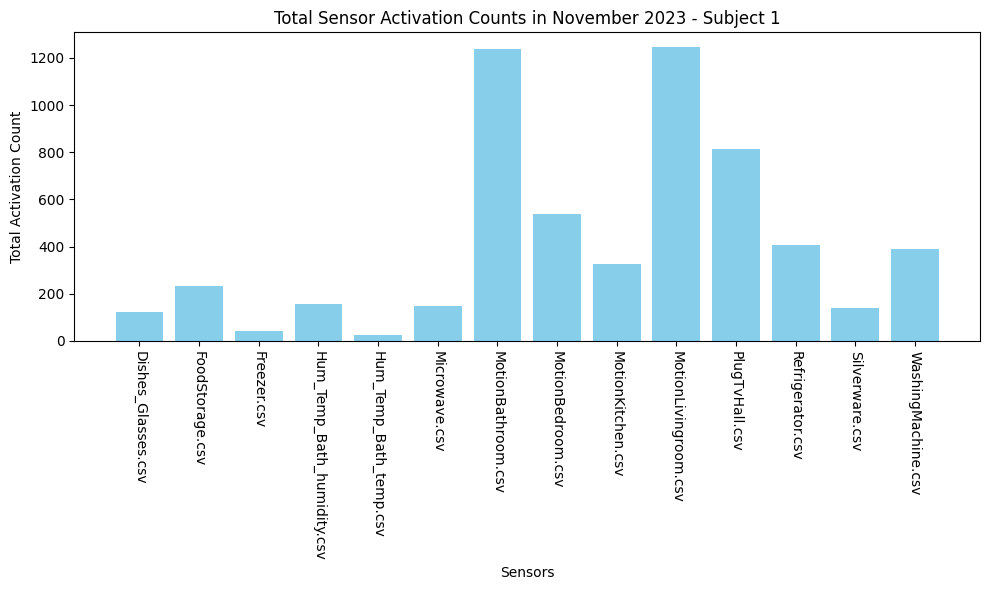

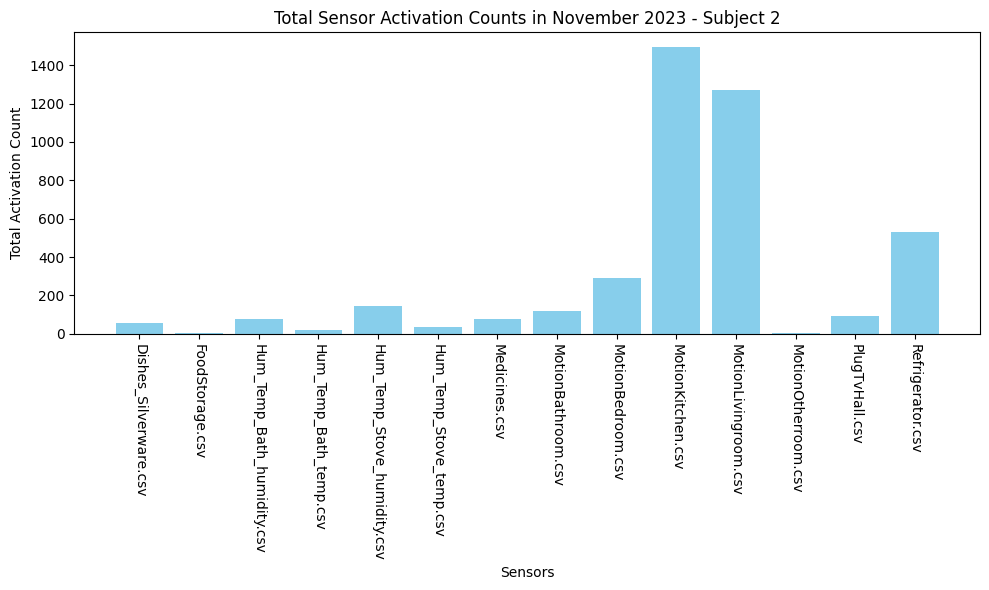

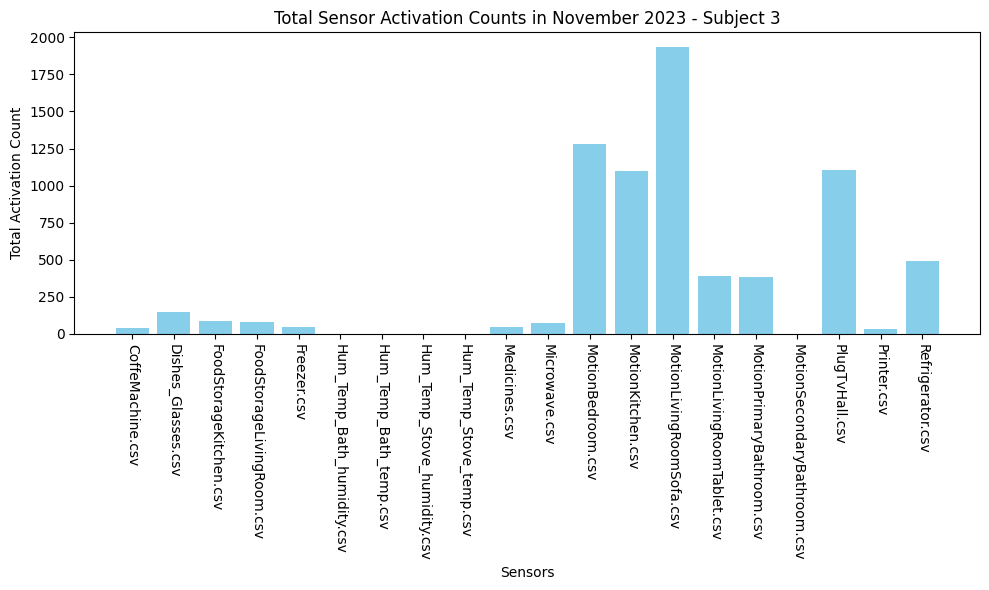

In [19]:
# %% Monthly analysis
for subject_index in range(len(subject_data)):
    df = subject_data[subject_index].copy()
    total_activation_counts = {}

    # Iterate over each sensor to find its activation count within the month
    for j in range(len(df)):
        if j == 9:
            continue  # Skip the sensor with index 9

        sensor = df[j]['sensor']
        current_data = df[j]['filtered_df']
        
        if len(current_data) > 0:
            # Filter the data for the specific month
            filtered_data = filter_data_for_month(current_data, '2023-11')
            activation_count = len(filtered_data)

            # Accumulate the activation count for each sensor
            if sensor in total_activation_counts:
                total_activation_counts[sensor] += activation_count
            else:
                total_activation_counts[sensor] = activation_count

    # Prepare data for plotting
    sensors = list(total_activation_counts.keys())
    activation_counts = list(total_activation_counts.values())

    # Plotting the total activation counts for each sensor in the month
    plt.figure(figsize=(10, 6))
    plt.bar(sensors, activation_counts, color='skyblue')

    # Add titles and labels
    plt.title(f'Total Sensor Activation Counts in November 2023 - Subject {subject_index+1}')
    plt.xlabel('Sensors')
    plt.ylabel('Total Activation Count')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=-90)

    # Display the plot
    plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap
    plt.show()

# Number of times sensor activated between one door close and next door open event

In [8]:
# Step 1: Filter specific month data
df = subject_data[2].copy()
house_entrance_df = df[9]['filtered_df'].copy()
house_entrance_df['ts_on'] = pd.to_datetime(house_entrance_df['ts_on'])
house_entrance_df_specific_month = house_entrance_df[(house_entrance_df['ts_on'].dt.year == 2023) & (house_entrance_df['ts_on'].dt.month == 11)]
# print(house_entrance_df_specific_month)

In [9]:
# Initialize a dictionary to accumulate activation counts
cumulative_activation_counts = {}

for i in range(1, 20):  # Adjust to the length of your dataset as needed
    current_off_time = house_entrance_df_specific_month.iloc[i-1]['ts_off']
    next_on_time = house_entrance_df_specific_month.iloc[i]['ts_on']
    time_difference = next_on_time - current_off_time
    print(next_on_time, current_off_time, time_difference)

    for j in range(len(df)):
        if j == 9:
            continue

        sensor = df[j]['sensor']
        current_data = df[j]['filtered_df']

        if len(current_data) > 0:
            if current_off_time.date() == next_on_time.date():
                filtered_data = filter_data_for_date(current_data, current_off_time.date())
            else:
                filtered_data_current_date = filter_data_for_date(current_data, current_off_time.date())
                filtered_data_next_date = filter_data_for_date(current_data, next_on_time.date())
                filtered_data = pd.concat([filtered_data_current_date, filtered_data_next_date], ignore_index=True)

            temp_df = filtered_data[(filtered_data['ts_on'] >= current_off_time) & (filtered_data['ts_on'] <= next_on_time)]

            # Accumulate activation counts
            if sensor not in cumulative_activation_counts:
                cumulative_activation_counts[sensor] = 0

            cumulative_activation_counts[sensor] += len(temp_df)

# Plot the accumulated activation counts
sensors = list(cumulative_activation_counts.keys())
activation_counts = list(cumulative_activation_counts.values())

fig = go.Figure(data=[go.Bar(x=sensors, y=activation_counts)])
fig.update_layout(
    title='Cumulative Sensor Activation Counts',
    xaxis_title='Sensors',
    yaxis_title='Activation Count',
    xaxis_tickangle=-90,
    template='plotly_white'
)

fig.show()


2023-11-01 07:39:58.971000 2023-11-01 07:39:34.397000 0 days 00:00:24.574000
2023-11-01 09:59:54.167000 2023-11-01 07:40:33.301000 0 days 02:19:20.866000
2023-11-01 10:18:46.923000 2023-11-01 10:00:03.535000 0 days 00:18:43.388000
2023-11-01 10:39:39.645000 2023-11-01 10:18:55.051000 0 days 00:20:44.594000
2023-11-01 14:07:01.742000 2023-11-01 10:39:43.887000 0 days 03:27:17.855000
2023-11-01 16:38:11.801000 2023-11-01 14:07:10.232000 0 days 02:31:01.569000
2023-11-01 18:44:31.926000 2023-11-01 16:43:58.569000 0 days 02:00:33.357000
2023-11-02 07:30:49.673000 2023-11-01 18:44:44.870000 0 days 12:46:04.803000
2023-11-02 08:42:55.868000 2023-11-02 07:31:26.527000 0 days 01:11:29.341000
2023-11-02 09:33:16.793000 2023-11-02 08:46:35.073000 0 days 00:46:41.720000
2023-11-02 09:44:06.383000 2023-11-02 09:33:29.973000 0 days 00:10:36.410000
2023-11-02 11:43:11.941000 2023-11-02 09:44:13.821000 0 days 01:58:58.120000
2023-11-02 13:44:34.476000 2023-11-02 11:44:15.537000 0 days 02:00:18.939000

In [45]:
# Step 2 Now iterate of door off and next door on  and check when the sensor was not active
for i in range(1,20):#len(house_entrance_df_specific_month)):
    current_off_time = house_entrance_df_specific_month.iloc[i-1]['ts_off']
    next_on_time = house_entrance_df_specific_month.iloc[i]['ts_on']
    time_difference = next_on_time - current_off_time
    print(next_on_time, current_off_time, time_difference)

    activated_sensors = []
    for j in range(len(df)):
        if j == 9:
            continue

        sensor = df[j]['sensor']
        current_data = df[j]['filtered_df']
        if len(current_data) > 0:
            # print(sensor)
            # print(current_data.head())
            if current_off_time.date() == next_on_time.date():
                # If date is same for both values of window
                filtered_data = filter_data_for_date(current_data, current_off_time.date())
            else:
                # If date is different for both values of window
                # In this case concat the data for both dates
                filtered_data_current_date = filter_data_for_date(current_data, current_off_time.date())
                filtered_data_next_date = filter_data_for_date(current_data, next_on_time.date())
                filtered_data = pd.concat([filtered_data_current_date, filtered_data_next_date], ignore_index=True)

            temp_df = filtered_data[(filtered_data['ts_on'] >= current_off_time) & (filtered_data['ts_on'] <= next_on_time)]
            if len(temp_df) > 0:
                activated_sensors.append({'senosr':sensor, 'activation_count':len(temp_df)})
            else:
                activated_sensors.append({'senosr':sensor, 'activation_count':0})

    sensors = [item['senosr'] for item in activated_sensors]
    activation_counts = [item['activation_count'] for item in activated_sensors]

    fig = go.Figure(data=[go.Bar(x=sensors, y=activation_counts)])
    fig.update_layout(
        title='Sensor Activation Counts',
        xaxis_title='Sensors',
        yaxis_title='Activation Count',
        xaxis_tickangle=-90,
        template='plotly_white'
    )

    fig.show() 
    sensors = []
    activation_counts = []   

        # if j == 9:
        #     print(temp['sensor'])      

2023-11-01 07:39:58.971000 2023-11-01 07:39:34.397000 0 days 00:00:24.574000


2023-11-01 09:59:54.167000 2023-11-01 07:40:33.301000 0 days 02:19:20.866000


2023-11-01 10:18:46.923000 2023-11-01 10:00:03.535000 0 days 00:18:43.388000


2023-11-01 10:39:39.645000 2023-11-01 10:18:55.051000 0 days 00:20:44.594000


2023-11-01 14:07:01.742000 2023-11-01 10:39:43.887000 0 days 03:27:17.855000


2023-11-01 16:38:11.801000 2023-11-01 14:07:10.232000 0 days 02:31:01.569000


2023-11-01 18:44:31.926000 2023-11-01 16:43:58.569000 0 days 02:00:33.357000


2023-11-02 07:30:49.673000 2023-11-01 18:44:44.870000 0 days 12:46:04.803000


2023-11-02 08:42:55.868000 2023-11-02 07:31:26.527000 0 days 01:11:29.341000


2023-11-02 09:33:16.793000 2023-11-02 08:46:35.073000 0 days 00:46:41.720000


2023-11-02 09:44:06.383000 2023-11-02 09:33:29.973000 0 days 00:10:36.410000


2023-11-02 11:43:11.941000 2023-11-02 09:44:13.821000 0 days 01:58:58.120000


2023-11-02 13:44:34.476000 2023-11-02 11:44:15.537000 0 days 02:00:18.939000


2023-11-02 13:48:03.283000 2023-11-02 13:44:56.766000 0 days 00:03:06.517000


2023-11-02 14:28:56.884000 2023-11-02 13:48:20.821000 0 days 00:40:36.063000


2023-11-02 14:35:00.858000 2023-11-02 14:33:50.208000 0 days 00:01:10.650000


2023-11-02 15:21:05.137000 2023-11-02 14:35:24.077000 0 days 00:45:41.060000


2023-11-02 22:48:59.391000 2023-11-02 15:23:20.114000 0 days 07:25:39.277000


2023-11-02 23:01:10.192000 2023-11-02 22:49:14.676000 0 days 00:11:55.516000


In [229]:
x

[]

# How many times subject was outside in a week for a given month?

In [10]:
# Step 1: Filter specific month data
df = subject_data[2].copy()
house_entrance_df = df[9]['filtered_df'].copy()

house_entrance_df['ts_on'] = pd.to_datetime(house_entrance_df['ts_on'])
house_entrance_df_specific_month = house_entrance_df[(house_entrance_df['ts_on'].dt.year == 2023) & (house_entrance_df['ts_on'].dt.month == 11)]
house_entrance_df_specific_month = house_entrance_df_specific_month.reset_index(drop = True)

house_entrance_df_specific_month['week'] = house_entrance_df_specific_month['ts_on'].dt.isocalendar().week
grouped_by_week = house_entrance_df_specific_month.groupby('week')
grouped_list = list(grouped_by_week)

# print(house_entrance_df_specific_month)

In [67]:

for w in range(len(grouped_list)): ## Iterate over weekly house enterance data
    week, week_data = grouped_list[w]
    if not week_data.empty:
        week_df = week_data
        for i in range(1,len(week_df)): ## For each house in and out event
            current_off_time = week_df.iloc[i-1]['ts_off']
            next_on_time = week_df.iloc[i]['ts_on']
            time_difference = next_on_time - current_off_time
            # print('---------------------------------------------------------')
            # print(next_on_time, current_off_time, time_difference)
            on_off_diff = []
            activated_sensors = []
            for j in range(len(df)): # iterate over each sensor
                if j == 9:
                    continue

                sensor = df[j]['sensor']
                current_data = df[j]['filtered_df']
                if len(current_data) > 0:
                    filtered = current_data[(current_data['ts_on'] >= current_off_time) & (current_data['ts_off'] <= next_on_time)]
                    if not filtered.empty:     
                        activated_sensors.append({'sensor':sensor, 'count': len(filtered)})
                    else:
                        pass

            if len(activated_sensors) == 0:
                on_off_diff.append([next_on_time, current_off_time, time_difference])
        plot_duration_distribution2(on_off_diff)


---------------------------------------------------------
2023-11-01 07:39:58.971000 2023-11-01 07:39:34.397000 0 days 00:00:24.574000
---------------------------------------------------------
2023-11-01 09:59:54.167000 2023-11-01 07:40:33.301000 0 days 02:19:20.866000
---------------------------------------------------------
2023-11-01 10:18:46.923000 2023-11-01 10:00:03.535000 0 days 00:18:43.388000
---------------------------------------------------------
2023-11-01 10:39:39.645000 2023-11-01 10:18:55.051000 0 days 00:20:44.594000
---------------------------------------------------------
2023-11-01 14:07:01.742000 2023-11-01 10:39:43.887000 0 days 03:27:17.855000
---------------------------------------------------------
2023-11-01 16:38:11.801000 2023-11-01 14:07:10.232000 0 days 02:31:01.569000
---------------------------------------------------------
2023-11-01 18:44:31.926000 2023-11-01 16:43:58.569000 0 days 02:00:33.357000
-------------------------------------------------------

---------------------------------------------------------
2023-11-06 09:48:05.787000 2023-11-06 07:37:23.060000 0 days 02:10:42.727000
---------------------------------------------------------
2023-11-06 09:51:01.539000 2023-11-06 09:48:12.692000 0 days 00:02:48.847000
---------------------------------------------------------
2023-11-06 10:00:46.018000 2023-11-06 09:51:11.713000 0 days 00:09:34.305000
---------------------------------------------------------
2023-11-06 14:56:43.895000 2023-11-06 10:00:50.740000 0 days 04:55:53.155000
---------------------------------------------------------
2023-11-06 15:25:19.362000 2023-11-06 14:56:51.081000 0 days 00:28:28.281000
---------------------------------------------------------
2023-11-06 15:40:40.774000 2023-11-06 15:25:26.367000 0 days 00:15:14.407000
---------------------------------------------------------
2023-11-06 17:27:24.431000 2023-11-06 15:40:47.254000 0 days 01:46:37.177000
-------------------------------------------------------

---------------------------------------------------------
2023-11-13 10:11:21.949000 2023-11-13 07:57:09.871000 0 days 02:14:12.078000
---------------------------------------------------------
2023-11-13 10:21:16.424000 2023-11-13 10:15:33.959000 0 days 00:05:42.465000
---------------------------------------------------------
2023-11-13 11:59:47.665000 2023-11-13 10:21:29.965000 0 days 01:38:17.700000
---------------------------------------------------------
2023-11-13 13:03:56.482000 2023-11-13 11:59:58.176000 0 days 01:03:58.306000
---------------------------------------------------------
2023-11-13 15:48:24.726000 2023-11-13 13:06:37.983000 0 days 02:41:46.743000
---------------------------------------------------------
2023-11-13 17:19:23.352000 2023-11-13 15:48:31.896000 0 days 01:30:51.456000
---------------------------------------------------------
2023-11-13 18:26:04.250000 2023-11-13 17:19:31.691000 0 days 01:06:32.559000
-------------------------------------------------------

---------------------------------------------------------
2023-11-20 09:06:22.657000 2023-11-20 08:00:07.753000 0 days 01:06:14.904000
---------------------------------------------------------
2023-11-20 09:12:08.722000 2023-11-20 09:06:38.782000 0 days 00:05:29.940000
---------------------------------------------------------
2023-11-20 12:06:18.636000 2023-11-20 09:12:15.318000 0 days 02:54:03.318000
---------------------------------------------------------
2023-11-20 12:06:36.674000 2023-11-20 12:06:36.470000 0 days 00:00:00.204000
---------------------------------------------------------
2023-11-20 12:06:39.729000 2023-11-20 12:06:39.262000 0 days 00:00:00.467000
---------------------------------------------------------
2023-11-20 12:16:43.833000 2023-11-20 12:16:42.802000 0 days 00:00:01.031000
---------------------------------------------------------
2023-11-20 15:25:01.074000 2023-11-20 12:16:50.615000 0 days 03:08:10.459000
-------------------------------------------------------

---------------------------------------------------------
2023-11-27 09:58:16.009000 2023-11-27 07:43:50.084000 0 days 02:14:25.925000
---------------------------------------------------------
2023-11-27 15:56:36.701000 2023-11-27 09:58:24.711000 0 days 05:58:11.990000
---------------------------------------------------------
2023-11-27 16:12:08.246000 2023-11-27 15:57:12.273000 0 days 00:14:55.973000
---------------------------------------------------------
2023-11-27 16:15:17.054000 2023-11-27 16:13:53.755000 0 days 00:01:23.299000
---------------------------------------------------------
2023-11-27 17:13:59.271000 2023-11-27 16:15:35.236000 0 days 00:58:24.035000
---------------------------------------------------------
2023-11-28 07:29:40.641000 2023-11-27 17:14:11.013000 0 days 14:15:29.628000
---------------------------------------------------------
2023-11-28 07:30:42.939000 2023-11-28 07:29:48.719000 0 days 00:00:54.220000
-------------------------------------------------------